<a href="https://colab.research.google.com/github/ddovidovich/DataScienceLerning/blob/main/UNIT_15_DZ_Ultra_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В рамках задания **Ультра-ПРО** вам предлагается воспользоваться фреймворком **Chainer**.

Используя произвольный датасет (CIFAR10, CIFAR100 или любой другой, в том числе свой собственный), создайте и обучите GAN с применением инструментов фреймворка **Chainer**

[Ссылка на документацию](https://docs.chainer.org/en/stable/index.html)

Установка chainer:

In [ ]:
!pip install chainer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967735 sha256=b366a965b7a8af489ae6b1a008a82ce16688f13156088e71ed948fd1efde1113
  Stored in directory: /root/.cache/pip/wheels/83/90/84/57741aca5962d73dbeb37ee7a859d3cc31463273a133821071
Successfully built chainer


In [ ]:
import os

import numpy as np

import chainer
from chainer import cuda
import chainer.functions as F
import chainer.links as L
from chainer import Variable
from chainer.training import extensions


chainer.print_runtime_info()

Platform: Linux-5.10.147+-x86_64-with-glibc2.31
Chainer: 7.8.1
ChainerX: Not Available
NumPy: 1.22.4
CuPy:
  OS                           : Linux-5.10.147+-x86_64-with-glibc2.31
  Python Version               : 3.9.16
  CuPy Version                 : 11.0.0
  CuPy Platform                : NVIDIA CUDA
  NumPy Version                : 1.22.4
  SciPy Version                : 1.10.1
  Cython Build Version         : 0.29.24
  Cython Runtime Version       : 0.29.33
  CUDA Root                    : /usr/local/cuda
  nvcc PATH                    : /usr/local/cuda/bin/nvcc
  CUDA Build Version           : 11070
  CUDA Driver Version          : 12000
  CUDA Runtime Version         : 11080
  cuBLAS Version               : 111103
  cuFFT Version                : 10900
  cuRAND Version               : 10300
  cuSOLVER Version             : (11, 4, 1)
  cuSPARSE Version             : 11705
  NVRTC Version                : (11, 8)
  Thrust Version               : 101500
  CUB Build Version          

### Создадим и обучим GAN. 
Для этого мы будем использовать две сети: генератор и дискриминатор.
Генератор будет генерировать изображения, которые будут пытаться обмануть дискриминатор, который будет пытаться отличить настоящие изображения от фальшивых.
Для начала зададим исходные параметры:

In [ ]:
# параметры 
n_epoch = 100  # количество эпох
n_hidden = 100  # количество скрытых нейронов
batchsize = 50  # минимальный batch size
snapshot_interval = 10000  # количество итераций до снимка
display_interval = 100  # количество итераций до вывода статуса
gpu_id = 0 # использование gpu
out_dir = 'result'
seed = 0  # random seed

In [ ]:
# Загрузка нормированных данных CIFAR10 без меток классов 
train, _ = chainer.datasets.get_cifar100(withlabel=False, scale=255.)

In [ ]:
train_iter = chainer.iterators.SerialIterator(train, batchsize)

**Создание генератора:**

In [ ]:
class Generator(chainer.Chain):

    def __init__(self, n_hidden, bottom_width=4, ch=512, wscale=0.02):
        super(Generator, self).__init__()
        self.n_hidden = n_hidden
        self.ch = ch
        self.bottom_width = bottom_width

        with self.init_scope():
            w = chainer.initializers.Normal(wscale)
            self.l0 = L.Linear(self.n_hidden, bottom_width * bottom_width * ch,
                               initialW=w)
            self.dc1 = L.Deconvolution2D(ch, ch // 2, 4, 2, 1, initialW=w)
            self.dc2 = L.Deconvolution2D(ch // 2, ch // 4, 4, 2, 1, initialW=w)
            self.dc3 = L.Deconvolution2D(ch // 4, ch // 8, 4, 2, 1, initialW=w)
            self.dc4 = L.Deconvolution2D(ch // 8, 3, 3, 1, 1, initialW=w)
            self.bn0 = L.BatchNormalization(bottom_width * bottom_width * ch)
            self.bn1 = L.BatchNormalization(ch // 2)
            self.bn2 = L.BatchNormalization(ch // 4)
            self.bn3 = L.BatchNormalization(ch // 8)

    def make_hidden(self, batchsize):
        return np.random.uniform(-1, 1, (batchsize, self.n_hidden, 1, 1)).astype(np.float32)

    def __call__(self, z):
        h = F.reshape(F.relu(self.bn0(self.l0(z))),
                                (len(z), self.ch, self.bottom_width, self.bottom_width))
        h = F.relu(self.bn1(self.dc1(h)))
        h = F.relu(self.bn2(self.dc2(h)))
        h = F.relu(self.bn3(self.dc3(h)))
        x = F.sigmoid(self.dc4(h))
        return x

**Создание дискриминатора:**

In [ ]:
class Discriminator(chainer.Chain):

    def __init__(self, bottom_width=4, ch=512, wscale=0.02):
        w = chainer.initializers.Normal(wscale)
        super(Discriminator, self).__init__()
        with self.init_scope():
            self.c0_0 = L.Convolution2D(3, ch // 8, 3, 1, 1, initialW=w)
            self.c0_1 = L.Convolution2D(ch // 8, ch // 4, 4, 2, 1, initialW=w)
            self.c1_0 = L.Convolution2D(ch // 4, ch // 4, 3, 1, 1, initialW=w)
            self.c1_1 = L.Convolution2D(ch // 4, ch // 2, 4, 2, 1, initialW=w)
            self.c2_0 = L.Convolution2D(ch // 2, ch // 2, 3, 1, 1, initialW=w)
            self.c2_1 = L.Convolution2D(ch // 2, ch // 1, 4, 2, 1, initialW=w)
            self.c3_0 = L.Convolution2D(ch // 1, ch // 1, 3, 1, 1, initialW=w)
            self.l4 = L.Linear(bottom_width * bottom_width * ch, 1, initialW=w)
            self.bn0_1 = L.BatchNormalization(ch // 4, use_gamma=False)
            self.bn1_0 = L.BatchNormalization(ch // 4, use_gamma=False)
            self.bn1_1 = L.BatchNormalization(ch // 2, use_gamma=False)
            self.bn2_0 = L.BatchNormalization(ch // 2, use_gamma=False)
            self.bn2_1 = L.BatchNormalization(ch // 1, use_gamma=False)
            self.bn3_0 = L.BatchNormalization(ch // 1, use_gamma=False)

    def __call__(self, x):
        h = add_noise(x)
        h = F.leaky_relu(add_noise(self.c0_0(h)))
        h = F.leaky_relu(add_noise(self.bn0_1(self.c0_1(h))))
        h = F.leaky_relu(add_noise(self.bn1_0(self.c1_0(h))))
        h = F.leaky_relu(add_noise(self.bn1_1(self.c1_1(h))))
        h = F.leaky_relu(add_noise(self.bn2_0(self.c2_0(h))))
        h = F.leaky_relu(add_noise(self.bn2_1(self.c2_1(h))))
        h = F.leaky_relu(add_noise(self.bn3_0(self.c3_0(h))))
        return self.l4(h)

**Добавим функцию генерации шума:**

In [ ]:
def add_noise(h, sigma=0.2):
    xp = cuda.get_array_module(h.data)
    if chainer.config.train:
        return h + sigma * xp.random.randn(*h.shape)
    else:
        return h

In [ ]:
gen = Generator(n_hidden=n_hidden)
dis = Discriminator()

In [ ]:
# Setup an optimizer
def make_optimizer(model, alpha=0.0002, beta1=0.5):
    optimizer = chainer.optimizers.Adam(alpha=alpha, beta1=beta1)
    optimizer.setup(model)
    optimizer.add_hook(
        chainer.optimizer_hooks.WeightDecay(0.0001), 'hook_dec')
    return optimizer

In [ ]:
opt_gen = make_optimizer(gen)
opt_dis = make_optimizer(dis)

Конструктор **DCGANUpdater** принимает на вход итератор, генератор, дискриминатор, оптимизаторы и устройство, на котором будет происходить обучение.

In [ ]:
class DCGANUpdater(chainer.training.updaters.StandardUpdater):

    def __init__(self, *args, **kwargs):
        self.gen, self.dis = kwargs.pop('models')
        super(DCGANUpdater, self).__init__(*args, **kwargs)

    def loss_dis(self, dis, y_fake, y_real):
        batchsize = len(y_fake)
        L1 = F.sum(F.softplus(-y_real)) / batchsize
        L2 = F.sum(F.softplus(y_fake)) / batchsize
        loss = L1 + L2
        chainer.report({'loss': loss}, dis)
        return loss

    def loss_gen(self, gen, y_fake):
        batchsize = len(y_fake)
        loss = F.sum(F.softplus(-y_fake)) / batchsize
        chainer.report({'loss': loss}, gen)
        return loss

    def update_core(self):
        gen_optimizer = self.get_optimizer('gen')
        dis_optimizer = self.get_optimizer('dis')

        batch = self.get_iterator('main').next()
        x_real = Variable(self.converter(batch, self.device)) / 255.
        xp = chainer.backends.cuda.get_array_module(x_real.data)

        gen, dis = self.gen, self.dis
        batchsize = len(batch)

        y_real = dis(x_real)

        z = Variable(xp.asarray(gen.make_hidden(batchsize)))
        x_fake = gen(z)
        y_fake = dis(x_fake)

        dis_optimizer.update(self.loss_dis, dis, y_fake, y_real)
        gen_optimizer.update(self.loss_gen, gen, y_fake)

In [ ]:
updater = DCGANUpdater(
      models=(gen, dis),
      iterator=train_iter,
      optimizer={
          'gen': opt_gen, 'dis': opt_dis},
      device=gpu_id)
trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'), out=out_dir)

Создадим функцию вывода сгенерированных картинок в файл:

In [ ]:
from PIL import Image
import chainer.backends.cuda


def out_generated_image(gen, dis, rows, cols, seed, dst):
    @chainer.training.make_extension()
    def make_image(trainer):
        np.random.seed(seed)
        n_images = rows * cols
        xp = gen.xp
        z = Variable(xp.asarray(gen.make_hidden(n_images)))
        with chainer.using_config('train', False):
            x = gen(z)
        x = chainer.backends.cuda.to_cpu(x.data)
        np.random.seed()

        x = np.asarray(np.clip(x * 255, 0.0, 255.0), dtype=np.uint8)
        _, _, H, W = x.shape
        x = x.reshape((rows, cols, 3, H, W))
        x = x.transpose(0, 3, 1, 4, 2)
        x = x.reshape((rows * H, cols * W, 3))

        preview_dir = '{}/preview'.format(dst)
        preview_path = preview_dir +\
            '/image{:0>8}.png'.format(trainer.updater.iteration)
        if not os.path.exists(preview_dir):
            os.makedirs(preview_dir)
        Image.fromarray(x).save(preview_path)
    return make_image

In [ ]:
snapshot_interval = (snapshot_interval, 'iteration')
display_interval = (display_interval, 'iteration')
trainer.extend(
    extensions.snapshot(filename='snapshot_iter_{.updater.iteration}.npz'),
    trigger=snapshot_interval)
trainer.extend(extensions.snapshot_object(
    gen, 'gen_iter_{.updater.iteration}.npz'), trigger=snapshot_interval)
trainer.extend(extensions.snapshot_object(
    dis, 'dis_iter_{.updater.iteration}.npz'), trigger=snapshot_interval)
trainer.extend(extensions.LogReport(trigger=display_interval))
trainer.extend(extensions.PrintReport([
    'epoch', 'iteration', 'gen/loss', 'dis/loss',
]), trigger=display_interval)
trainer.extend(extensions.ProgressBar(update_interval=100))
trainer.extend(
    out_generated_image(
        gen, dis,
        5, 5, seed, out_dir),
    trigger=snapshot_interval)

In [ ]:
# Запуск обучения
trainer.run()

/usr/local/lib/python3.9/dist-packages/chainer/functions/connection/convolution_2d.py:295: PerformanceWarning: The best algo of conv fwd might not be selected due to lack of workspace size (8388608)
  cuda.cudnn.convolution_forward(


Streaming output truncated to the last 5000 lines.
this epoch [#####.............................................] 10.00%
       100 iter, 0 epoch / 100 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
0           200         1.09643     1.34239     
     total [..................................................]  0.20%
this epoch [##########........................................] 20.00%
       200 iter, 0 epoch / 100 epochs
    6.8862 iters/sec. Estimated time to finish: 4:01:32.729792.
0           300         0.943491    1.32969     
     total [..................................................]  0.30%
this epoch [###############...................................] 30.00%
       300 iter, 0 epoch / 100 epochs
    6.9737 iters/sec. Estimated time to finish: 3:58:16.557634.
0           400         0.987443    1.32607     
     total [..................................................]  0.40%
this epoch [####################..............................] 40.00%
      

In [ ]:
from IPython.display import Image, display_png
import glob

image_files = sorted(glob.glob(out_dir + '/preview/*.png'))

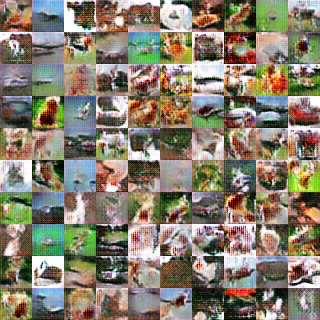

In [ ]:
display_png(Image(image_files[0]))  # картинки сгенерированные в начале обучения

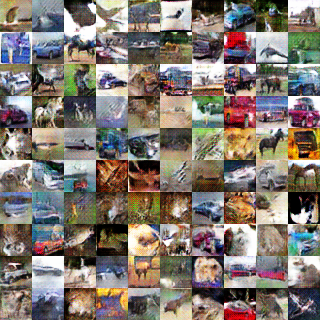

In [ ]:
display_png(Image(image_files[-1]))  # картинки сгенерированные в конце обучения